# **FlagGAN1 Model: DCGAN-based modification**

*For full project, please visit [AI4M - Project: Part two](https://colab.research.google.com/drive/1KImfZDSffEtrVuPuhPrXQncrWKa5S4q8?usp=sharing)*  

*For part one outcome, please visit [AI4M - Project: Part one outcome](https://drive.google.com/drive/folders/1F4xeTCrMXJARISmJdfAmQD2KYoV8TWJ4)*  


*   [Inspiration: AI-generated Emoji Project](https://process.studio/works/aimoji-ai-generated-emoji/)
*   [DCGAN Paper](https://paperswithcode.com/method/dcgan)



***This notebook edits upon week 5 notebook from IU000133 : Artificial Intelligence for Media [AI4Mdia Introduction to DCGAN](https://git.arts.ac.uk/jmurr/ai-for-media-2022/tree/main/05-1_dcgan)***



In [ ]:
'''
For running with local device,
downloading and upgrading below packages. 

!pip install numpy
!pip install tensorflow
!pip install opencv-python
!pip install --upgrade tensorflow keras numpy pandas sklearn pillow

'''

'\nFor running with local device,\ndownloading and upgrading below packages. \n\n!pip install numpy\n!pip install tensorflow\n!pip install opencv-python\n!pip install --upgrade tensorflow keras numpy pandas sklearn pillow\n\n'

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import random
import shutil
import os,os.path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from google.colab import drive #dataset is saved on googledrive 
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [ ]:
DATASET_DIR = r'C:\Users\21036265\Desktop\country_flags_resize' #path to input
OUTPUT_DIR = r'C:\Users\21036265\Desktop\test_07' #path to outcome
#DATASET_DIR_RESIZE = 'drive/MyDrive/country flags resize' #path to resized file
os.makedirs(OUTPUT_DIR) 

In [ ]:
preprocess = True



*Upscale Image from 250px to 256 px, method in cv2.INTER_AREA*

ref: [cv2-resize](https://machinelearningknowledge.ai/how-to-scale-and-resize-image-in-python-with-opencv-cv2-resize/
)

* use Boolean to check file format in the original dataset









In [ ]:
img_height = 256
img_width = 256 

In [ ]:
if preprocess == True:
    os.makedirs(DATASET_DIR_RESIZE)
    for img in os.listdir(DATASET_DIR):
      image_resize = cv2.imread(os.path.join(DATASET_DIR, img))
      #print (image_resize.shape) 
      #Skip non-image file in original dataset
      if image_resize is None:  
        continue
      image_resize = cv2.resize(image_resize, (img_height,img_width), cv2.INTER_AREA) 
      cv2.imwrite(os.path.join(DATASET_DIR_RESIZE, img), image_resize) 

In [ ]:
#shutil.rmtree(DATASET_DIR_RESIZE) 

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    label_mode=None,
    image_size=(img_height, img_width),
    batch_size=2,
    seed=999,
    validation_split=0.01, 
    subset='training' 
)
dataset = dataset.map(lambda x: x / 255.0) 

Found 270 files belonging to 1 classes.
Using 268 files for training.


## Re-edit discriminator and generator based on 05-1 Notebook
ref: [AI4Media 05-1](https://git.arts.ac.uk/jmurr/ai-for-media-2022/blob/main/05-1_dcgan/01_DCGAN_custom_dataset.ipynb)

In [ ]:
discriminator = keras.Sequential(
    [
        
    #add Gaussian noise to prevent overfitting
        layers.GaussianNoise(0.2, input_shape = (img_height, img_width, 3)),
        
    #1. Build four augumentation layers without affecting resized image
    #2. Updated dataset contains 270 * 3 files 
    #ref: tf.keras.layers.experimental.preprocessing 
        
        layers.RandomFlip(mode="horizontal_and_vertical"),
        layers.RandomRotation(factor=0.3, fill_mode = "reflect"),
        layers.RandomZoom(height_factor=(0.2,0.5),width_factor=(0.2,0.5),fill_mode="wrap"),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),

    #DCGAN model, add 25% drop rate to prevent additional fitting
     
     #256 * 256
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
     #128 * 128 
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
     #64 * 64
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
     #32 * 32
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
     #16 * 16
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
     #8 * 8
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.25),
     #4 * 4
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 256, 256, 3)      0         
 se)                                                             
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_translation (RandomT  (None, 256, 256, 3)      0         
 ranslation)                                                     
                                                     

In [ ]:
latent_dim = 100
generator = keras.Sequential(
    [
     #add batchnormalization to original model: speed up generating process
     #Input 
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 128),
        layers.Reshape((4, 4, 128)),
     #4 * 4 
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(momentum = 0.7), 
        layers.LeakyReLU(alpha=0.2),
     #8 * 8
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(momentum = 0.7), 
        layers.LeakyReLU(alpha=0.2),
     #16 * 16
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(momentum = 0.7), 
        layers.LeakyReLU(alpha=0.2),
     #32 * 32
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(momentum = 0.7), 
        layers.LeakyReLU(alpha=0.2),
     #64 * 64
        layers.Conv2DTranspose(4, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(momentum = 0.7), 
        layers.LeakyReLU(alpha=0.2),
     #128 * 128
        layers.Conv2DTranspose(4, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
     #256 * 256
     #activation switch: sigmoid or tanh
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"), 
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 2048)              206848    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 8, 8, 128)        262272    
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 16, 16, 64)       13

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))

## Compile generator and discriminator and start training

* first training, 200, ~16min, colab, sigmoid: test_01
* second training, 250, ~29min, colab, sigmoid: test_02
* third training, 500, ~76min, colab, sigmoid: test_03
* fourth training, 750, ~25min, colab,tanh: test_04 
* fifth training, 1000, ~32min, local, tanh: test_05
* sixth training, 1000, ~32min, local, sigmoid: test_06
* seventh training, 750, ~25min, local, sigmoid: test_07

In [ ]:
epochs = 750

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/750
134/134 [==============================] - 4s 18ms/step - d_loss: 0.7407 - g_loss: 28.9848
Epoch 2/750
134/134 [==============================] - 2s 18ms/step - d_loss: -0.1308 - g_loss: 58.2886
Epoch 3/750
134/134 [==============================] - 2s 18ms/step - d_loss: -361.6433 - g_loss: 38760.2148
Epoch 4/750
134/134 [==============================] - 2s 18ms/step - d_loss: -2003.8417 - g_loss: 251153.1094
Epoch 5/750
134/134 [==============================] - 2s 18ms/step - d_loss: -6951.2935 - g_loss: 1157965.7500
Epoch 6/750
134/134 [==============================] - 2s 18ms/step - d_loss: -5992.9878 - g_loss: 1296474.7500
Epoch 7/750
134/134 [==============================] - 2s 19ms/step - d_loss: 312.6999 - g_loss: 304666.3438
Epoch 8/750
134/134 [==============================] - 3s 19ms/step - d_loss: -2542.1028 - g_loss: 1055706.7500
Epoch 9/750
134/134 [==============================] - 2s 19ms/step - d_loss: 1890.7649 - g_loss: 1218.6868
Epoch 10/750
134/134

134/134 [==============================] - 2s 19ms/step - d_loss: 6.0515 - g_loss: 113.9704
Epoch 155/750
134/134 [==============================] - 2s 18ms/step - d_loss: 9.3251 - g_loss: 133.7551
Epoch 156/750
134/134 [==============================] - 2s 18ms/step - d_loss: 3.8260 - g_loss: 104.5264
Epoch 157/750
134/134 [==============================] - 2s 18ms/step - d_loss: 5.0801 - g_loss: 118.6431
Epoch 158/750
134/134 [==============================] - 2s 18ms/step - d_loss: 2.5015 - g_loss: 77.1109
Epoch 159/750
134/134 [==============================] - 2s 18ms/step - d_loss: 3.1485 - g_loss: 127.2837
Epoch 160/750
134/134 [==============================] - 2s 18ms/step - d_loss: 3.4558 - g_loss: 99.1869
Epoch 161/750
134/134 [==============================] - 2s 18ms/step - d_loss: 2.2712 - g_loss: 188.4194
Epoch 162/750
134/134 [==============================] - 2s 18ms/step - d_loss: 3.8713 - g_loss: 143.4181
Epoch 163/750
134/134 [==============================] - 2s 18

134/134 [==============================] - 2s 18ms/step - d_loss: 2.0260 - g_loss: 23.0022
Epoch 233/750
134/134 [==============================] - 2s 18ms/step - d_loss: 2.0161 - g_loss: 36.8840
Epoch 234/750
134/134 [==============================] - 2s 18ms/step - d_loss: 2.1008 - g_loss: 29.0205
Epoch 235/750
134/134 [==============================] - 2s 18ms/step - d_loss: 1.7559 - g_loss: 26.8487
Epoch 236/750
134/134 [==============================] - 2s 18ms/step - d_loss: 1.3883 - g_loss: 23.8078
Epoch 237/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.9626 - g_loss: 24.9005
Epoch 238/750
134/134 [==============================] - 2s 18ms/step - d_loss: 1.2748 - g_loss: 25.0104
Epoch 239/750
134/134 [==============================] - 2s 18ms/step - d_loss: 1.3955 - g_loss: 33.3135
Epoch 240/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.6737 - g_loss: 37.5630
Epoch 241/750
134/134 [==============================] - 2s 18ms/step

134/134 [==============================] - 2s 18ms/step - d_loss: 0.1180 - g_loss: 17.9856
Epoch 389/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.0317 - g_loss: 20.5584
Epoch 390/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.0758 - g_loss: 19.5836
Epoch 391/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.0944 - g_loss: 23.4767
Epoch 392/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.3805 - g_loss: 21.2360
Epoch 393/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.2900 - g_loss: 22.9322
Epoch 394/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.1312 - g_loss: 29.2661
Epoch 395/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.2130 - g_loss: 31.5684
Epoch 396/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.0876 - g_loss: 34.2627
Epoch 397/750
134/134 [==============================] - 2s 18ms/step

134/134 [==============================] - 3s 19ms/step - d_loss: 0.1693 - g_loss: 18.8419
Epoch 545/750
134/134 [==============================] - 3s 19ms/step - d_loss: 0.1164 - g_loss: 17.3984
Epoch 546/750
134/134 [==============================] - 3s 19ms/step - d_loss: 0.3026 - g_loss: 21.8174
Epoch 547/750
134/134 [==============================] - 3s 19ms/step - d_loss: 0.3110 - g_loss: 21.1462
Epoch 548/750
134/134 [==============================] - 3s 19ms/step - d_loss: 0.2422 - g_loss: 22.2871
Epoch 549/750
134/134 [==============================] - 2s 19ms/step - d_loss: 0.2557 - g_loss: 23.8945
Epoch 550/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.4778 - g_loss: 15.8917
Epoch 551/750
134/134 [==============================] - 3s 19ms/step - d_loss: 0.4195 - g_loss: 20.4839
Epoch 552/750
134/134 [==============================] - 3s 19ms/step - d_loss: 0.3214 - g_loss: 23.9190
Epoch 553/750
134/134 [==============================] - 3s 19ms/step

134/134 [==============================] - 2s 18ms/step - d_loss: 0.2494 - g_loss: 15.6782
Epoch 623/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.2532 - g_loss: 15.7525
Epoch 624/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.2435 - g_loss: 14.2708
Epoch 625/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.2658 - g_loss: 13.6862
Epoch 626/750
134/134 [==============================] - 2s 19ms/step - d_loss: 0.2201 - g_loss: 15.4057
Epoch 627/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.2238 - g_loss: 14.1116
Epoch 628/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.2674 - g_loss: 16.8699
Epoch 629/750
134/134 [==============================] - 2s 18ms/step - d_loss: 0.1918 - g_loss: 16.2533
Epoch 630/750
134/134 [==============================] - 2s 19ms/step - d_loss: 0.2592 - g_loss: 15.8631
Epoch 631/750
134/134 [==============================] - 2s 18ms/step

In [ ]:
#clear output
#shutil.rmtree(OUTPUT_DIR) 

## Display Result

###Single image check

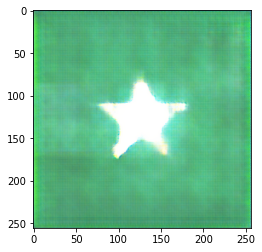

In [ ]:
OUTPUT_DIR_NEW = 'drive/MyDrive/output/test_04'
epoch, i = 605, 4
result = plt.imread(os.path.join(OUTPUT_DIR_NEW, f'generated_img_{epoch}_{i}.png'))
plt.imshow(result) 

###Create a gif

ref: [Imageio document](https://imageio.readthedocs.io/en/stable/examples.html)

In [ ]:
import imageio

In [ ]:
datafile_path = 'drive/MyDrive/output/test_07'
output_file = '/content/drive/MyDrive/output/output_gif/test_07.gif'

In [ ]:
files = os.listdir(datafile_path)
images_path = [os.path.join(datafile_path,file) for file in files]

In [ ]:
"""
fps are the frames per second
1. 16-18 old school movie style
2. 24 standard video 

"""
images = []
for img in images_path:
    if img.endswith('png'):
      images.append(imageio.imread(img))
imageio.mimsave(output_file, images, fps= 35)

Check if gif file exists

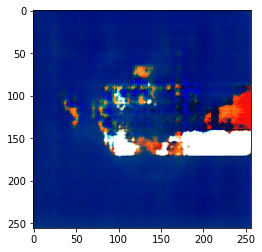

In [ ]:
img = mpimg.imread(output_file)
plt.imshow(img)